In [34]:
import torch                                                                
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [35]:
def jacobian(y, x, create_graph=False):                                                               
    jac = []                                                                                          
    flat_y = y.reshape(-1)                                                                            
    grad_y = torch.zeros_like(flat_y)                                                                 
    for i in range(len(flat_y)):                                                                      
        grad_y[i] = 1.                                                                                
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph)
        jac.append(grad_x.reshape(x.shape))                                                           
        grad_y[i] = 0.                                                                                
    return torch.stack(jac).reshape(y.shape + x.shape)                                                
                                                                                                      
def hessian(y, x):                                                                                    
    return jacobian(jacobian(y, x, create_graph=True), x)  

def fisher(y,x):
    j = jacobian(y, x, create_graph=True)

    return torch.outer(j,j)                                        
                                                                                                      



In [36]:
def create_data(n_samples):
    X0 = torch.tensor(np.array([[np.random.normal(loc=-1, scale=1),
                    np.random.normal(loc=1, scale=1),
                    np.random.normal(loc=-1, scale=1),
                    np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]),requires_grad=False)


    X1 = torch.tensor(np.array([[np.random.normal(loc=1, scale=1),
                    np.random.normal(loc=-1, scale=1),
                    np.random.normal(loc=1, scale=1),
                    np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]),requires_grad=False)

    X = torch.cat((X0, X1),0)

    Y = torch.cat((torch.tensor(np.array([[1,0] for i in range(n_samples//2)])),
                   torch.tensor(np.array([[0,1] for i in range(n_samples//2)]))), 0)

    data = list(zip(X, Y))
    return data

In [37]:
def loss_single(prediction,label):
  delta = prediction-label
  return torch.dot(delta,delta)*1

def model(x,w):
  sig = nn.Sigmoid()

  layer_1 = torch.split(w,[16,24])
  w_1 = layer_1[0].reshape(4,4)
  x = sig(torch.matmul(x,w_1))

  layer_2 = torch.split(layer_1[1],[16,8])
  w_2 = layer_2[0].reshape(4,4)
  x = sig(torch.matmul(x,w_2))

  w_3 = layer_2[1].reshape(4,2)
  x = torch.matmul(x,w_3)
  return x

def loss_avg(data,w):
  n_samples=len(data)
  loss_tot = 0
  Fisher = torch.zeros((40,40))
  for x,y in data:
      prediction = model(x,w)
      #loss_tot += loss_single(F.softmax(prediction),y)
      loss_tot += F.cross_entropy(prediction.view(1,2),y[1].view(1,))
      Fisher += fisher(loss_single(prediction,y),w)
  #print(Fisher)
  return loss_tot,Fisher/n_samples

In [38]:
def sample_theta_for_fisher(n_iter,data,plots=False):
    EV = []
    FR = []
    Rank = []
    all_w = []
    all_fishers=[]
    for i in range(n_iter):
      print('Sample ',i,end='\r')
      w = torch.tensor(np.random.uniform(size=(40,),low=-1.0,high=1.0),requires_grad=True)
      total_loss, Fisher = loss_avg(data,w)
      EV = np.append(EV,torch.eig(Fisher, eigenvectors=False,  out=None)[0][:,0].detach().numpy())
      with torch.no_grad():
        Rank.append(torch.matrix_rank(Fisher).item())
        Fw = np.matmul(Fisher.numpy(),w.numpy())
        wFw = np.dot(w,Fw)
        FR.append(wFw)
        all_w.append(w)
        all_fishers.append(Fisher)
    if plots:
        print("Fisher")
        x, bins, p=plt.hist(EV, bins=None,range=None)
        for item in p:
          item.set_height(item.get_height()/(40*n_iter))
        plt.ylim(0,1)
        plt.title("Sigmoid")
        plt.show()

        plt.hist(Rank)
        plt.title('matrix ranks for all Fisher')
        plt.show()
        plt.hist(FR)
        plt.title('Fisher-Rao norm for all Fisher')
        plt.show()

    return EV,FR,Rank,all_w,all_fishers

## Calculating Effective Dimension

In [39]:
#Function to normalise Fisher informations
def normalise_fishers(Fishers,thetas,d,V):
  num_samples = len(Fishers)

  TrF_integral = (1/num_samples) * torch.sum(torch.tensor([torch.trace(F) for F in Fishers]))
  return [((d*V)/TrF_integral)*F for F in Fishers]


In [40]:
#Function to calculate effective dimension
def effective_dimension(normed_fishers,n):
  d = 40
  V_theta = 1
  gamma = 1
  id = torch.eye(d)
  kappa = torch.tensor([(gamma*n)/(2*np.pi*np.log(n))])
  integral = torch.tensor([0.0])
  for F in normed_fishers:
    det = torch.det(id + kappa*F)
    integral += torch.sqrt(torch.det(id + kappa*F))
  integral_over_volume = integral/V_theta
  numerator = torch.log(integral_over_volume)
  return 2*numerator/torch.log(kappa)
    
  

Fisher  99
D_EFF =  tensor([16.2654], dtype=torch.float64, grad_fn=<DivBackward0>)


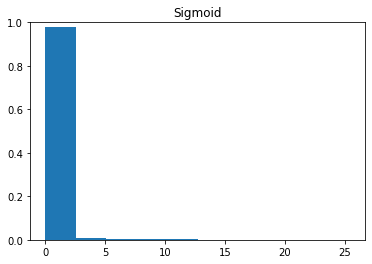

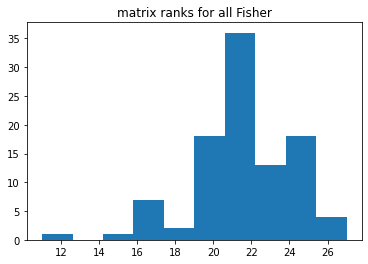

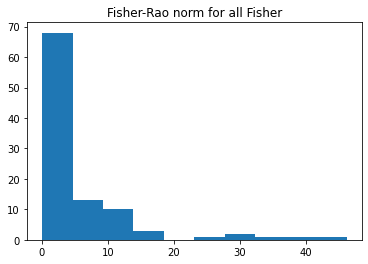

In [41]:
data = create_data(100)
EV,FR,Rank,all_w,all_fishers = sample_theta_for_fisher(100,data,plots=True)
nF = normalise_fishers(all_fishers,all_w,40,1)
ef = effective_dimension(nF,len(data))
print('D_EFF = ',ef)

## Figure 8 Reproduction

In [45]:
data = create_data(10000)
efs = []
for n_iters in range(10,110,10):
    EV,FR,Rank,all_w,all_fishers = sample_theta_for_fisher(n_iters,data,plots=False)
    nF = normalise_fishers(all_fishers,all_w,40,1)
    ef = effective_dimension(nF,len(data))
    print('D_EFF = ',ef)
    efs.append(ef)

D_EFF =  tensor([9.4004], dtype=torch.float64, grad_fn=<DivBackward0>)


KeyboardInterrupt: 